# Exploratory Analysis

In [67]:
from collections import Counter
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

In [3]:
sns.set(rc={'figure.figsize':(15,8)})

In [4]:
os.chdir('..')

In [5]:
game_files = os.listdir('./data/games')

In [6]:
tag_freqs = []
for game in game_files:
    with open(f'./data/games/{game}', 'r') as in_json:
        game_data = json.load(in_json)
        game_tags = game_data['tags']
        if game_tags:
            for k, v in game_tags.items():
                tag_freqs.append(v)

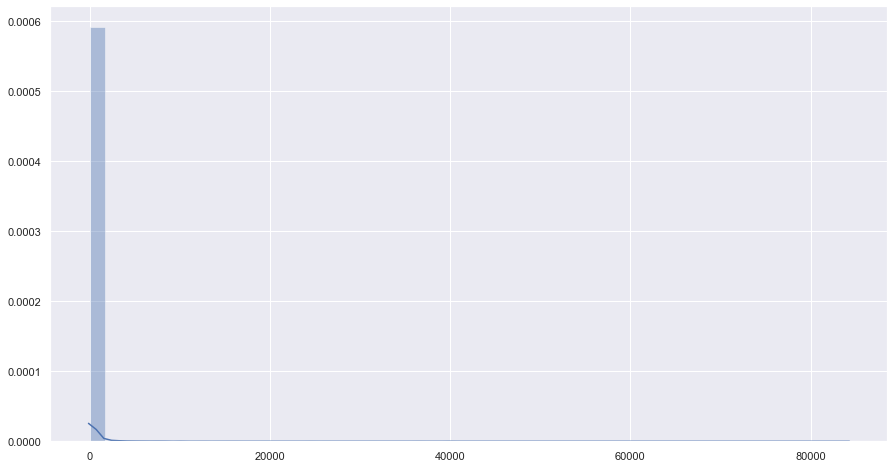

In [7]:
sns.distplot(tag_freqs)

In [8]:
np.mean(tag_freqs)

66.53283525749076

In [9]:
np.median(tag_freqs)

22.0

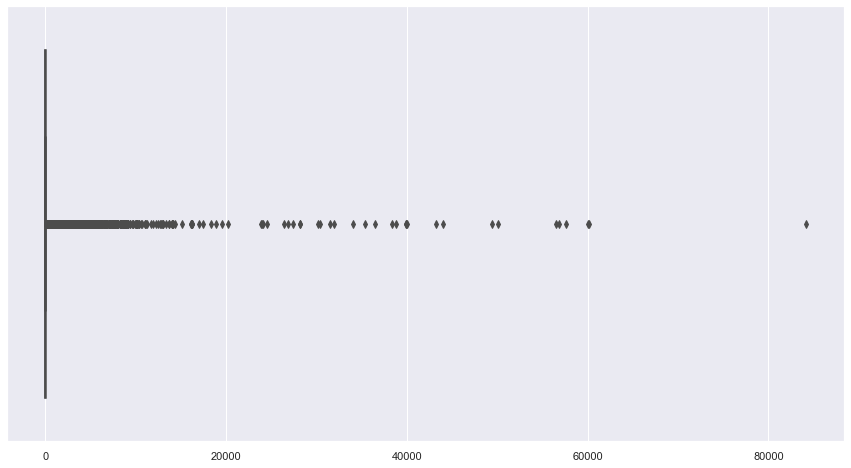

In [10]:
sns.boxplot(x=tag_freqs)

In [13]:
pd.Series(tag_freqs).describe()

count    267563.000000
mean         66.532835
std         549.068984
min           1.000000
25%          12.000000
50%          22.000000
75%          35.000000
max       84173.000000
dtype: float64

In [35]:
for i in np.linspace(0.05, 1, num=20):
    print(f'Qauntile: {i:.2f}   Frequency: {np.quantile(tag_freqs, i)}')

Qauntile: 0.05   Frequency: 7.0
Qauntile: 0.10   Frequency: 10.0
Qauntile: 0.15   Frequency: 11.0
Qauntile: 0.20   Frequency: 11.0
Qauntile: 0.25   Frequency: 12.0
Qauntile: 0.30   Frequency: 14.0
Qauntile: 0.35   Frequency: 17.0
Qauntile: 0.40   Frequency: 20.0
Qauntile: 0.45   Frequency: 21.0
Qauntile: 0.50   Frequency: 22.0
Qauntile: 0.55   Frequency: 23.0
Qauntile: 0.60   Frequency: 26.0
Qauntile: 0.65   Frequency: 30.0
Qauntile: 0.70   Frequency: 32.0
Qauntile: 0.75   Frequency: 35.0
Qauntile: 0.80   Frequency: 43.0
Qauntile: 0.85   Frequency: 55.0
Qauntile: 0.90   Frequency: 80.0
Qauntile: 0.95   Frequency: 163.0
Qauntile: 1.00   Frequency: 84173.0


In [36]:
len(tag_freqs)

267563

In [48]:
np.array(tag_freqs)[np.array(tag_freqs) > 100].shape

(21386,)

ImportError: Cumulative distributions are currentlyonly implemented in statsmodels.Please install statsmodels.

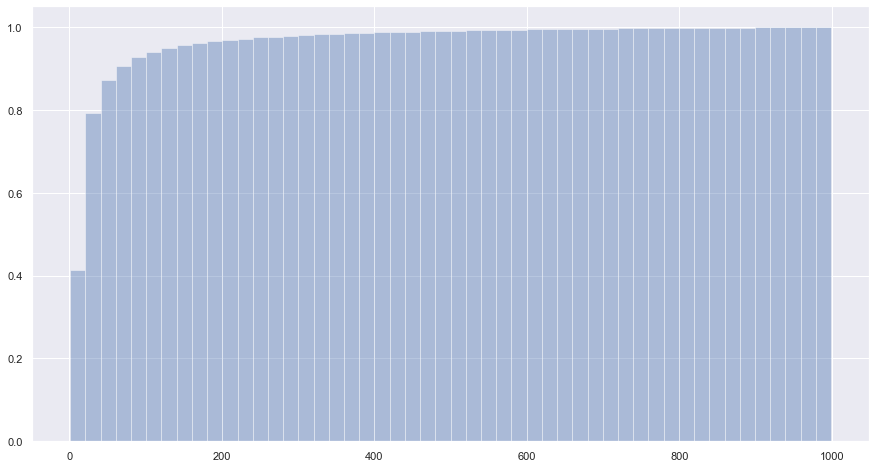

In [53]:
kwargs = {'cumulative': True}
sns.distplot([i for i in tag_freqs if i < 1000], hist_kws=kwargs, kde_kws=kwargs)

In [54]:
TAG_VOTES_MIN = 100

## Average Tag Frequency Per Game

In [57]:
tag_avg = []
for game in game_files:
    with open(f'./data/games/{game}', 'r') as in_json:
        game_data = json.load(in_json)
        game_tags = game_data['tags']
        if game_tags:
            filtered_tags = [i for i in game_tags.values() if i >= TAG_VOTES_MIN]
            if filtered_tags:
                tag_avg.append(np.array(filtered_tags).mean())
tag_avg = np.array(tag_avg)

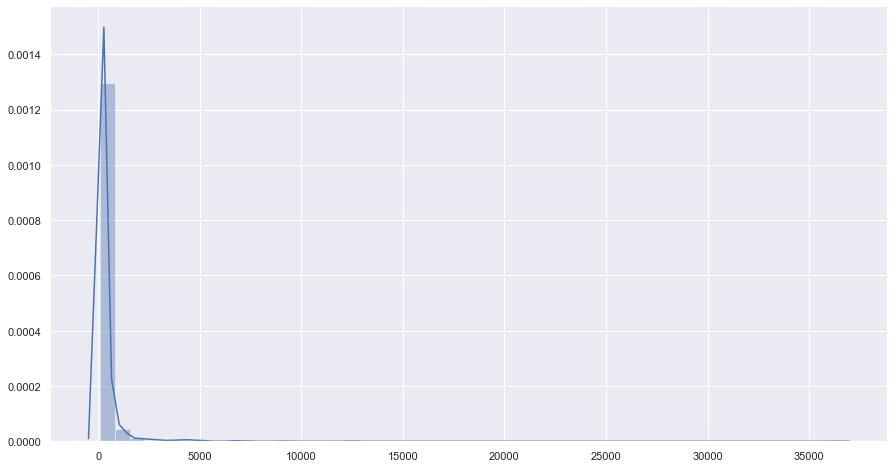

In [58]:
sns.distplot(tag_avg)

In [59]:
pd.Series(tag_avg).describe()

count     3092.000000
mean       334.837683
std        952.448827
min        100.000000
25%        123.500000
50%        156.250000
75%        254.046875
max      36412.650000
dtype: float64

## Tag Frequencies Per Game

In [60]:
tag_occurrence = {}
for game in game_files:
    with open(f'./data/games/{game}', 'r') as in_json:
        game_data = json.load(in_json)
        game_tags = game_data['tags']
        if game_tags:
            for k, v in game_tags.items():
                if v >= TAG_VOTES_MIN:
                    tag_occurrence[k] = tag_occurrence.get(k, 0) + 1

In [61]:
tag_occurrence['Action']

1166

In [62]:
pd.Series(list(tag_occurrence.values())).describe()

count     370.000000
mean       58.413514
std       131.034902
min         1.000000
25%         6.000000
50%        15.000000
75%        47.750000
max      1166.000000
dtype: float64

In [63]:
np.median(list(tag_occurrence.values()))

15.0

In [64]:
for i in np.linspace(0.05, 1, num=20):
    print(f'Qauntile: {i:.2f}   Frequency: {np.quantile(list(tag_occurrence.values()), i)}')

Qauntile: 0.05   Frequency: 1.0
Qauntile: 0.10   Frequency: 2.0
Qauntile: 0.15   Frequency: 4.0
Qauntile: 0.20   Frequency: 5.0
Qauntile: 0.25   Frequency: 6.0
Qauntile: 0.30   Frequency: 7.0
Qauntile: 0.35   Frequency: 9.0
Qauntile: 0.40   Frequency: 10.0
Qauntile: 0.45   Frequency: 12.0
Qauntile: 0.50   Frequency: 15.0
Qauntile: 0.55   Frequency: 17.0
Qauntile: 0.60   Frequency: 20.0
Qauntile: 0.65   Frequency: 27.0
Qauntile: 0.70   Frequency: 35.30000000000001
Qauntile: 0.75   Frequency: 47.75
Qauntile: 0.80   Frequency: 68.39999999999998
Qauntile: 0.85   Frequency: 88.0
Qauntile: 0.90   Frequency: 143.10000000000002
Qauntile: 0.95   Frequency: 266.70000000000016
Qauntile: 1.00   Frequency: 1166.0


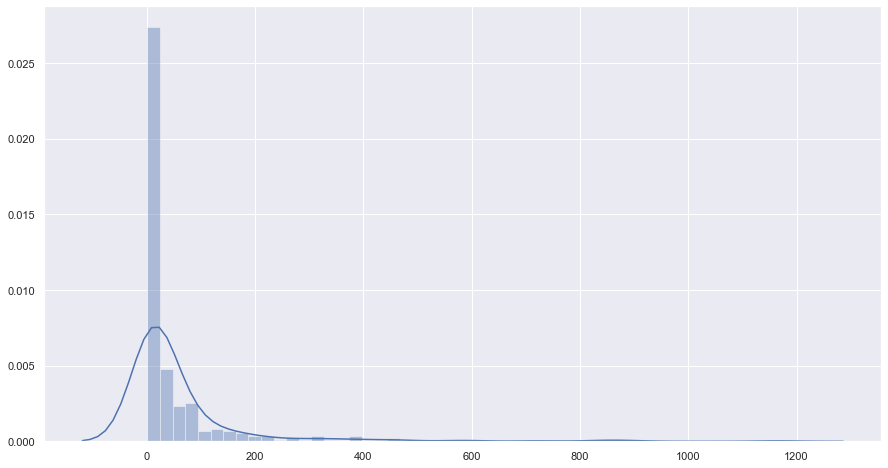

In [65]:
sns.distplot(list(tag_occurrence.values()))

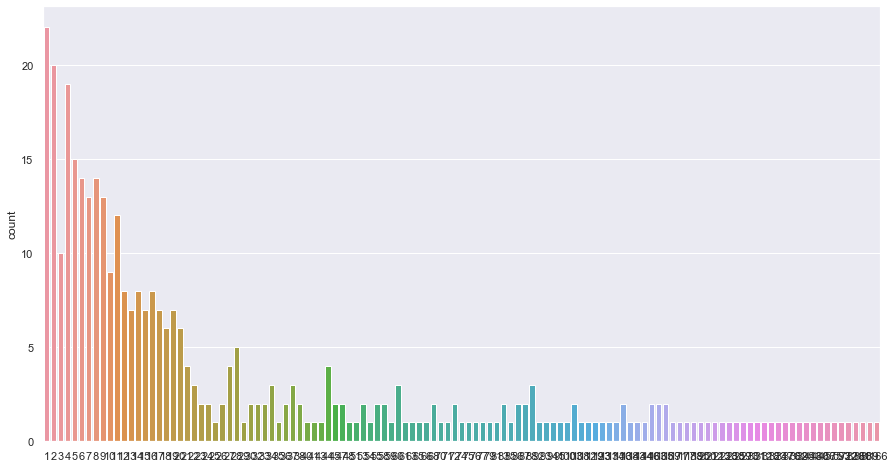

In [73]:
sns.countplot(list(tag_occurrence.values()))

In [79]:
tag_occurrence_vals = np.array(list(tag_occurrence.values()))
tag_occurrence_vals.shape

(370,)

In [ ]:
np.array(list(tag_occurrence.values()))

In [92]:
tag_occurrence_vals[tag_occurrence_vals > 10].shape

(221,)

In [93]:
MIN_TAG_FREQ_GAME = 10

In [95]:
game_tags_keep = {game : tag_occurrence[game] for game in tag_occurrence if tag_occurrence[game] >= MIN_TAG_FREQ_GAME}

In [111]:
final_data = {}
for game in game_files:
    with open(f'./data/games/{game}', 'r') as in_json:
        game_data = json.load(in_json)
        final_data[game_data['name']] = []
        game_tags = game_data['tags']
        if game_tags:
            for k, v in game_tags.items():
                if (k in game_tags_keep) and (v >= TAG_VOTES_MIN):
                    final_data[game_data['name']].append(k)

In [112]:
len(final_data)

33155

In [113]:
keys_to_remove = [k for k, v in final_data.items() if not v]
for key in keys_to_remove:
    final_data.pop(key, None)

In [114]:
len(final_data)

3070

In [115]:
with open('./games_with_tags_double_filter.json', 'w') as out:
    json.dump(final_data, out)

In [101]:
final_data['Rocket League']

['Multiplayer',
 'Competitive',
 'Sports',
 'Racing',
 'Team-Based',
 'Online Co-Op',
 'Fast-Paced',
 'Co-op',
 'Funny',
 'Action',
 'Great Soundtrack',
 'Local Multiplayer',
 'Split Screen',
 'Local Co-Op',
 'Singleplayer',
 '4 Player Local',
 'Casual',
 'Indie']

In [102]:
final_data['Age of Mythology: Extended Edition']

['Strategy',
 'Masterpiece',
 'RTS',
 'Classic',
 'Multiplayer',
 'Great Soundtrack',
 'Singleplayer',
 'Fantasy',
 'Simulation',
 'Historical',
 'Atmospheric',
 'Adventure',
 'Tactical',
 'Real-Time',
 'Story Rich',
 'Co-op',
 'Remake']

In [4]:
tag_games = os.listdir('./data')

In [53]:
games_with_tags = {}
tags_with_games = {}
for tag in tag_games:
    game_tag = tag.replace('_games.json', '').replace("'", '')
    tags_with_games[game_tag] = []
    with open(f'./data/{tag}') as in_json:
        data = json.load(in_json)
#         print(data)
        for k, v in data.items():
            print(k, v)
            tags_with_games[game_tag].append(v['name'])
            games_with_tags.setdefault(v['name'], []).append(game_tag)
            break
    break

10 {'appid': 10, 'name': 'Counter-Strike', 'developer': 'Valve', 'publisher': 'Valve', 'score_rank': '', 'positive': 143998, 'negative': 3749, 'userscore': 0, 'owners': '20,000,000 .. 50,000,000', 'average_forever': 11828, 'average_2weeks': 846, 'median_forever': 193, 'median_2weeks': 24, 'price': '99', 'initialprice': '999', 'discount': '90'}


In [6]:
sorted_tag_freq = sorted(tags_with_games.items(), key=lambda x: len(x[1]), reverse=True)

In [7]:
tag = []
tag_freq = []
for i in sorted_tag_freq:
    tag.append(i[0])
    tag_freq.append(len(i[1]))

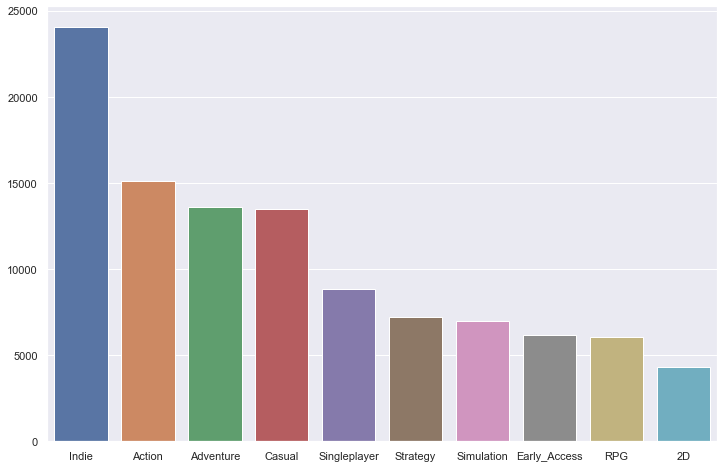

In [21]:
sns.barplot(tag[:10], tag_freq[:10])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 <a list of 60 Text xticklabel objects>)

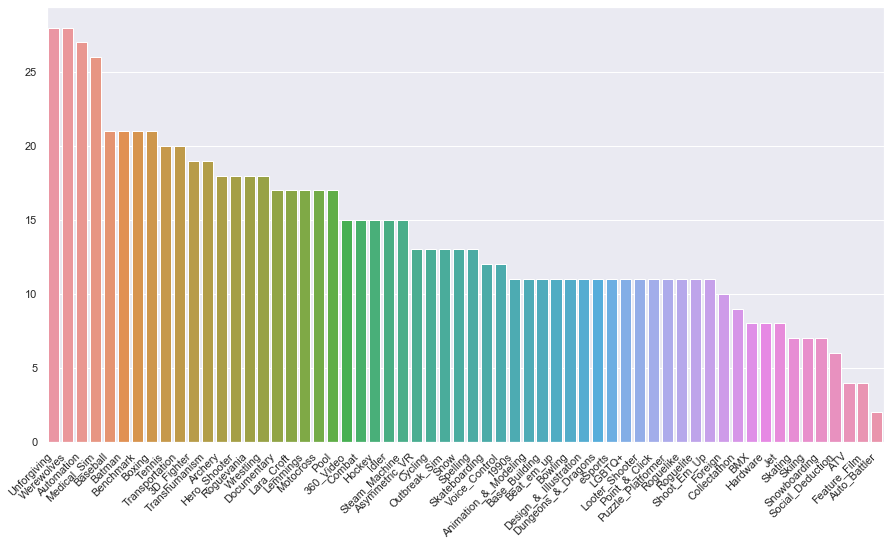

In [30]:
sns.barplot(tag[-60:], tag_freq[-60:])
plt.xticks(rotation=45, ha='right')

In [22]:
len(tag_freq)

408

In [13]:
np.mean(tag_freq)

675.0857843137255

In [14]:
np.median(tag_freq)

146.0

In [35]:
tag[-100:]

['Mod',
 'Star_Wars',
 'Warhammer_40K',
 'Conspiracy',
 'On-Rails_Shooter',
 'Sailing',
 'Mystery_Dungeon',
 'Sokoban',
 'Artificial_Intelligence',
 'Class-Based',
 'Sniper',
 'Traditional_Roguelike',
 'Horses',
 'Dynamic_Narration',
 'Golf',
 'Solitaire',
 'Precision_Platformer',
 'Motorbike',
 'Movie',
 'Pinball',
 'Bikes',
 'Gambling',
 'Rome',
 'Basketball',
 'Vehicular_Combat',
 'Diplomacy',
 'Combat_Racing',
 'Immersive_Sim',
 '2D_Platformer',
 'Conversation',
 'LEGO',
 'Life_Sim',
 'Sequel',
 'Submarine',
 'Tutorial',
 'Mini_Golf',
 'Gaming',
 'TrackIR',
 'Intentionally_Awkward_Controls',
 'Underground',
 'Unforgiving',
 'Werewolves',
 'Automation',
 'Medical_Sim',
 'Baseball',
 'Batman',
 'Benchmark',
 'Boxing',
 'Tennis',
 'Transportation',
 '3D_Fighter',
 'Transhumanism',
 'Archery',
 'Hero_Shooter',
 'Roguevania',
 'Wrestling',
 'Documentary',
 'Lara_Croft',
 'Lemmings',
 'Motocross',
 'Pool',
 '360_Video',
 'Combat',
 'Hockey',
 'Idler',
 'Steam_Machine',
 'Asymmetric_VR',


In [33]:
np.quantile(tag_freq, 0.25)

51.0

In [32]:
with open('./games_with_tags.json', 'w') as out:
    json.dump(games_with_tags, out)

In [41]:
print(tag_freq[-101])

50


In [40]:
print(tag_freq[-102])

51


In [36]:
to_remove = tag[-100:]

In [37]:
to_remove

['Mod',
 'Star_Wars',
 'Warhammer_40K',
 'Conspiracy',
 'On-Rails_Shooter',
 'Sailing',
 'Mystery_Dungeon',
 'Sokoban',
 'Artificial_Intelligence',
 'Class-Based',
 'Sniper',
 'Traditional_Roguelike',
 'Horses',
 'Dynamic_Narration',
 'Golf',
 'Solitaire',
 'Precision_Platformer',
 'Motorbike',
 'Movie',
 'Pinball',
 'Bikes',
 'Gambling',
 'Rome',
 'Basketball',
 'Vehicular_Combat',
 'Diplomacy',
 'Combat_Racing',
 'Immersive_Sim',
 '2D_Platformer',
 'Conversation',
 'LEGO',
 'Life_Sim',
 'Sequel',
 'Submarine',
 'Tutorial',
 'Mini_Golf',
 'Gaming',
 'TrackIR',
 'Intentionally_Awkward_Controls',
 'Underground',
 'Unforgiving',
 'Werewolves',
 'Automation',
 'Medical_Sim',
 'Baseball',
 'Batman',
 'Benchmark',
 'Boxing',
 'Tennis',
 'Transportation',
 '3D_Fighter',
 'Transhumanism',
 'Archery',
 'Hero_Shooter',
 'Roguevania',
 'Wrestling',
 'Documentary',
 'Lara_Croft',
 'Lemmings',
 'Motocross',
 'Pool',
 '360_Video',
 'Combat',
 'Hockey',
 'Idler',
 'Steam_Machine',
 'Asymmetric_VR',


In [43]:
games_with_tags_min_50_freq = {}
for tag in tag_games:
    game_tag = tag.replace('_games.json', '').replace("'", '')
    if game_tag in to_remove:
        continue
    with open(f'./data/{tag}') as in_json:
        data = json.load(in_json)
        for k, v in data.items():
            games_with_tags_min_50_freq.setdefault(v['name'], []).append(game_tag)

In [45]:
with open('./games_with_tags_min_50_freq.json', 'w') as out:
    json.dump(games_with_tags_min_50_freq, out)

In [49]:
games_with_tags_min_50_freq['Rocket League']

['4_Player_Local',
 'Action',
 'Casual',
 'Co-op',
 'Competitive',
 'Fast-Paced',
 'Football',
 'Free_to_Play',
 'Funny',
 'Great_Soundtrack',
 'Indie',
 'Local_Co-Op',
 'Local_Multiplayer',
 'Multiplayer',
 'Online_Co-Op',
 'Racing',
 'Singleplayer',
 'Soccer',
 'Split_Screen',
 'Sports',
 'Team-Based']

In [50]:
games_with_tags['Rocket League']

['4_Player_Local',
 'Action',
 'Casual',
 'Co-op',
 'Competitive',
 'Fast-Paced',
 'Football',
 'Free_to_Play',
 'Funny',
 'Great_Soundtrack',
 'Indie',
 'Local_Co-Op',
 'Local_Multiplayer',
 'Multiplayer',
 'Online_Co-Op',
 'Racing',
 'Singleplayer',
 'Soccer',
 'Split_Screen',
 'Sports',
 'Team-Based']